In [33]:
import matplotlib.pyplot as pl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from PIL import Image
from skimage.segmentation import mark_boundaries
from torchvision import transforms

from Models.VGG19_model import VGG19

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
vgg = VGG19(models.vgg19(weights="VGG19_Weights.DEFAULT"))
vgg.load_state_dict(torch.load("../assets/vgg19_transfer.pth", map_location=device))
vgg.eval()

/tmp/ipykernel_22439/3833509541.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg.load_state_dict(torch.load("../assets/vgg19_transfer.pth", map_location=device))


VGG19(
  (original_vgg19_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)

In [44]:
def explain_with_lime(model: nn.Module, image_path: str, target_class: int) -> None:
    image_transform = transforms.ToTensor()

    image = np.array(Image.open(image_path).convert("RGB").resize((224, 224)))

    def _batch_predict(images: np.ndarray) -> np.ndarray:
        # A function that takes a batch of images and returns a prediction for each image.
        batch = torch.stack(tuple(image_transform(i) for i in images), dim=0)
        batch = batch.to(device)
        logits = model(batch)
        probabilities = F.softmax(logits, dim=1)
        return probabilities.detach().numpy()

    explainer = lime_image.LimeImageExplainer()
    segmenter = SegmentationAlgorithm("quickshift")
    explanation = explainer.explain_instance(
        image=image,
        classifier_fn=_batch_predict,
        segmentation_fn=segmenter,
        num_samples=300
    )
    image, mask = explanation.get_image_and_mask(
        label=target_class, positive_only=False, num_features=1
    )
    marked_image = mark_boundaries(image / 255.0, mask)
    pl.figure(figsize=(10, 10))
    pl.imshow(marked_image)
    pl.title(image_path)
    pl.axis("off")
    pl.show()

In [37]:
images = []

image = Image.open("../assets/compression/meningioma_original.jpg")

image_50_compressed = image.copy()
image_50_compressed.save("../assets/compression/meningioma_50.jpg", quality=50, optimize=True)

image_1_compressed = image.copy()
image_1_compressed.save("../assets/compression/meningioma_1.jpg", quality=1, optimize=True)

image_20_compressed = image.copy()
image_20_compressed.save("../assets/compression/meningioma_20.jpg", quality=20, optimize=True)

images.append("../assets/compression/meningioma_original.jpg")
images.append("../assets/compression/meningioma_50.jpg")
images.append("../assets/compression/meningioma_1.jpg")
images.append("../assets/compression/meningioma_20.jpg")

In [38]:
classes: dict[int, str] = {0: "glioma", 1: "meningioma", 2: "notumor", 3: "pituitary"}

100%|██████████| 300/300 [01:25<00:00,  3.49it/s]


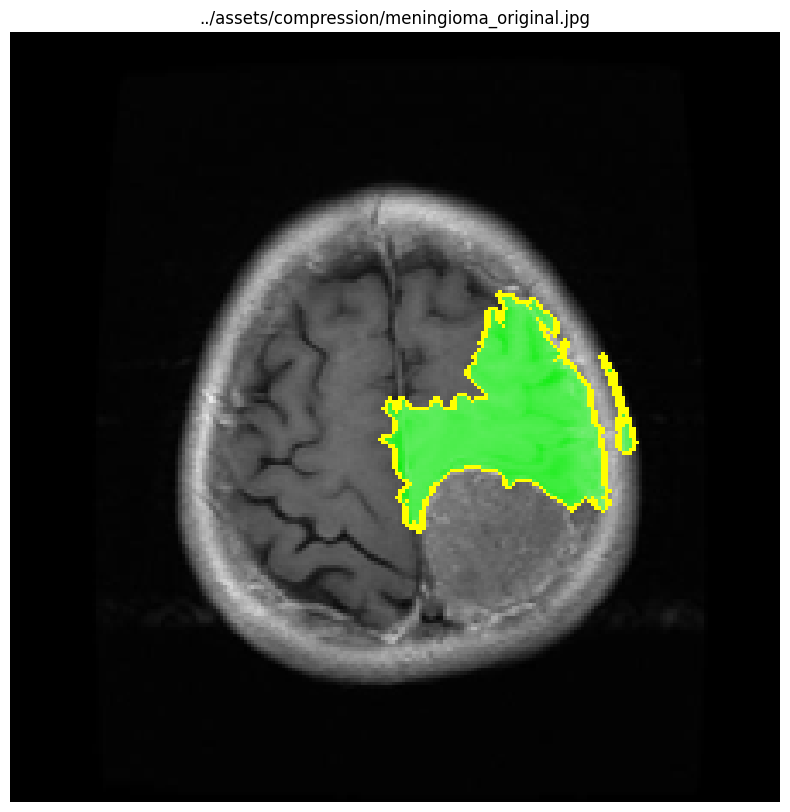

In [45]:
explain_with_lime(vgg, images[0], 1)

100%|██████████| 300/300 [01:30<00:00,  3.33it/s]


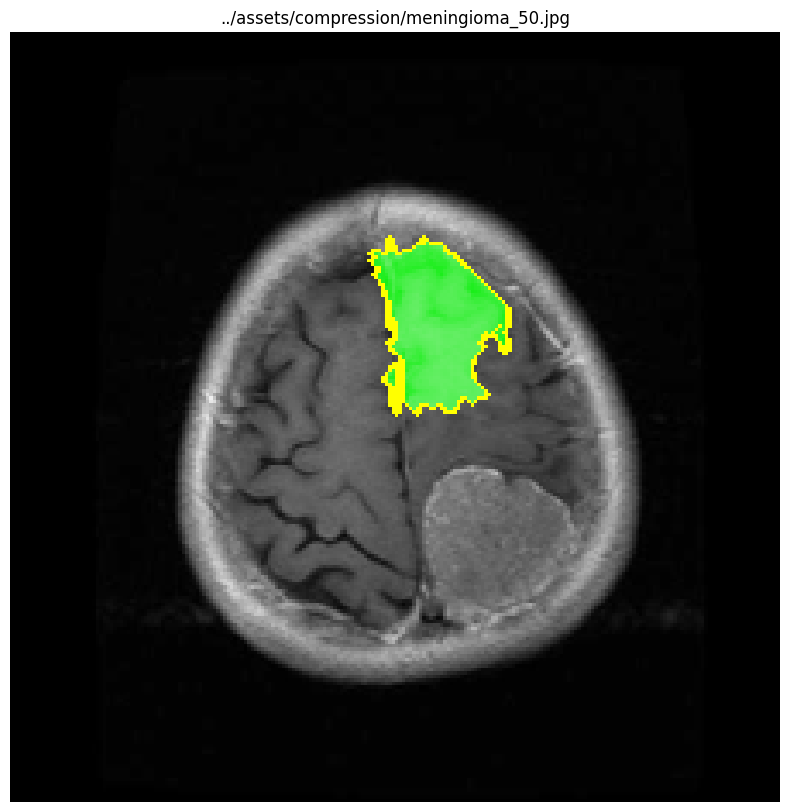

In [46]:
explain_with_lime(vgg, images[1], 1)

100%|██████████| 100/100 [00:25<00:00,  3.90it/s]


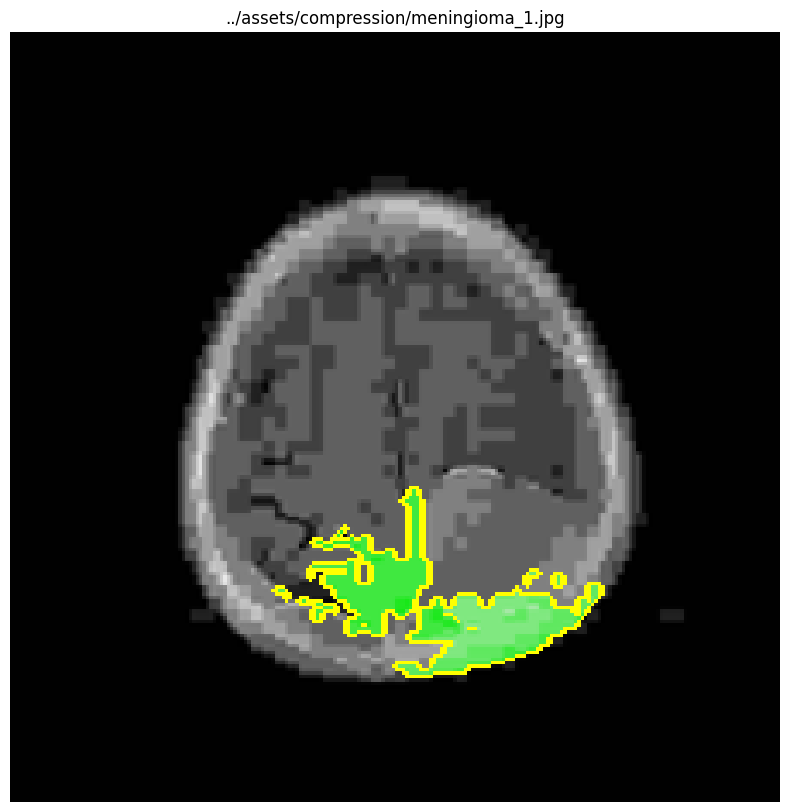

In [41]:
explain_with_lime(vgg, images[2], 1)

100%|██████████| 100/100 [00:27<00:00,  3.60it/s]


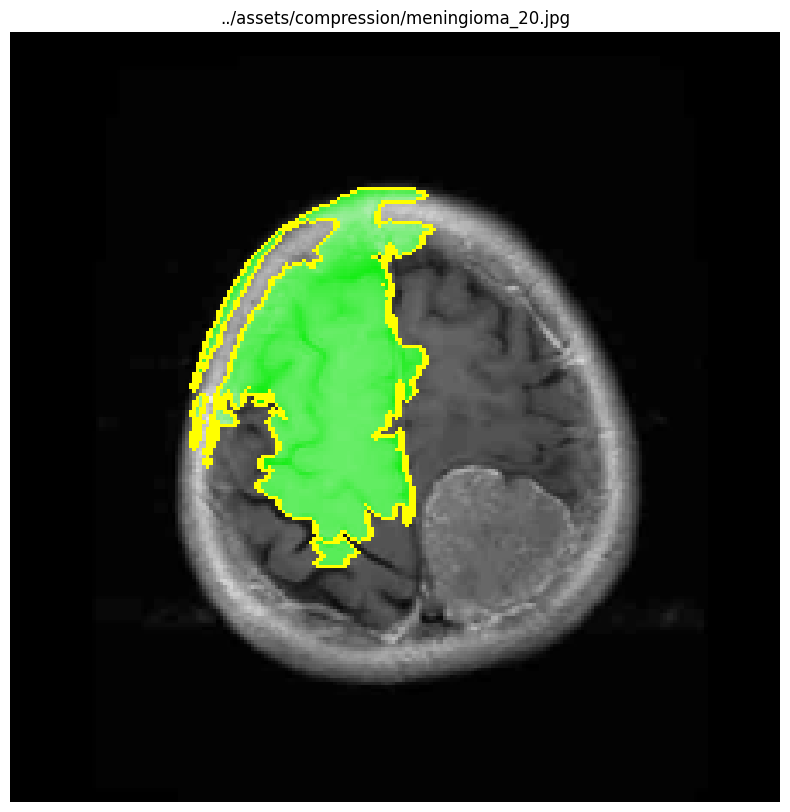

In [42]:
explain_with_lime(vgg, images[3], 1)